## This notebook generates Figures 3 and 4 of the paper "iCSD produces spurious results in dense electrode arrays"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from cinplaAnalysis.utils import *

%matplotlib ipympl

In [2]:
from cinplaAnalysis.icsd import StandardCSD, DeltaiCSD, StepiCSD

In [3]:
import matplotlib

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [4]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [5]:
def plotFig(ax,csd,breaks=None,absmax=None,timeLimited=False,plotCB=False,xlabels=False,title=None):

    if breaks is not None:
        for b in breaks:
            ax.plot([0,3000],[b,b],c='k')

    if absmax is None:
        absmax = np.max(np.abs(csd))

    rms = np.mean(np.sqrt(csd**2))
    
    im = ax.imshow(np.array(csd)/rms, origin='lower',cmap='bwr_r',vmin=-10,vmax=10)#, vmin =-absmax,vmax=absmax, cmap='bwr_r')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax)
        cb.formatter.set_powerlimits((0,0))


    ax.set_yticklabels([])

    if xlabels:
        ax.set_xticks([2000,2050],labels=['0','50'])
        # ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticklabels([])

    if timeLimited:
        ax.set_xlim([50,100])
    else:
        ax.set_xlim([2000,2050])

    if title:
        plt.title(title)

    plt.tight_layout()

In [6]:
# Loads oCSD averaged over trials, with 20 um spacing, for various values of rho

lowRes = np.load('radii/total.npy')

In [7]:
idx_200 = np.arange(101) # Indices in the output file for objective disk CSD with 200 um rho
idx_100 = np.arange(101,202) # Indices in the output file for objective disk CSD with 100 um rho
idx_50 = np.arange(202,303) # Indices in the output file for objective disk CSD with 500 um rho
idx_20 = np.arange(303,404) # Indices in the output file for objective disk CSD with 20 um rho
idx_10 = np.arange(404,505) # Indices in the output file for objective disk CSD with 10 um rho

disk200 = lowRes[:,idx_200]
disk100 = lowRes[:,idx_100]
disk50 = lowRes[:,idx_50]
disk20 = lowRes[:,idx_20]
disk10 = lowRes[:,idx_10]

In [9]:
originalData = np.load('highRes/total.npy') # Loads LFP and oCSD averaged over trials, 20 um spacing, rho=500um

disk_fullDensity_idx = np.arange(202,303)
disk500 = originalData[:,disk_fullDensity_idx] # oCSD, 20um spacing, rho = 500 um




In [ ]:
### Calculates oCSD for 40 and 80 um electrode spacing, with rho of 500 um, by taking the sum of neighboring electrodes in the 20 um case

disk500_lowRes = np.zeros([originalData.shape[0],51])
disk500_verylowRes = np.zeros([originalData.shape[0],26])

for l in range(disk500_lowRes.shape[1]):
    if l == 0:
        disk500_lowRes[:,l] = disk500[:,2*l]+.5*disk500[:,2*l+1]
    elif l == disk500_lowRes.shape[1]-1:
        disk500_lowRes[:,l] = disk500[:,2*l]+.5*disk500[:,2*l-1]
    else:
        disk500_lowRes[:,l] = disk500[:,2*l]+.5*disk500[:,2*l-1]+.5*disk500[:,2*l+1]

for l in range(disk500_verylowRes.shape[1]):
    if l == 0:
        disk500_verylowRes[:,l] = disk500_lowRes[:,2*l]+.5*disk500_lowRes[:,2*l+1]
    elif l == disk500_verylowRes.shape[1]-1:
        disk500_verylowRes[:,l] = disk500_lowRes[:,2*l]+.5*disk500_lowRes[:,2*l-1]
    else:
        disk500_verylowRes[:,l] = disk500_lowRes[:,2*l]+.5*disk500_lowRes[:,2*l-1]+.5*disk500_lowRes[:,2*l+1]

In [10]:
### Calculates oCSD for 40 um electrode spacing, with various rho, by taking the sum of neighboring electrodes in the 20 um case

disk200_lowRes = np.zeros([101,51])
disk100_lowRes = np.zeros([101,51])
disk50_lowRes = np.zeros([101,51])
disk20_lowRes = np.zeros([101,51])
disk10_lowRes = np.zeros([101,51])

for l in range(disk200_lowRes.shape[1]):
    if l == 0:
        disk200_lowRes[:,l] = disk200[:,2*l]+.5*disk200[:,2*l+1]
    elif l == disk200_lowRes.shape[1]-1:
        disk200_lowRes[:,l] = disk200[:,2*l]+.5*disk200[:,2*l-1]
    else:
        disk200_lowRes[:,l] = disk200[:,2*l]+.5*disk200[:,2*l-1]+.5*disk200[:,2*l+1]

for l in range(disk100_lowRes.shape[1]):
    if l == 0:
        disk100_lowRes[:,l] = disk100[:,2*l]+.5*disk100[:,2*l+1]
    elif l == disk100_lowRes.shape[1]-1:
        disk100_lowRes[:,l] = disk100[:,2*l]+.5*disk100[:,2*l-1]
    else:
        disk100_lowRes[:,l] = disk100[:,2*l]+.5*disk100[:,2*l-1]+.5*disk100[:,2*l+1]

for l in range(disk50_lowRes.shape[1]):
    if l == 0:
        disk50_lowRes[:,l] = disk50[:,2*l]+.5*disk50[:,2*l+1]
    elif l == disk50_lowRes.shape[1]-1:
        disk50_lowRes[:,l] = disk50[:,2*l]+.5*disk50[:,2*l-1]
    else:
        disk50_lowRes[:,l] = disk50[:,2*l]+.5*disk50[:,2*l-1]+.5*disk50[:,2*l+1]

for l in range(disk20_lowRes.shape[1]):
    if l == 0:
        disk20_lowRes[:,l] = disk20[:,2*l]+.5*disk20[:,2*l+1]
    elif l == disk20_lowRes.shape[1]-1:
        disk20_lowRes[:,l] = disk20[:,2*l]+.5*disk20[:,2*l-1]
    else:
        disk20_lowRes[:,l] = disk20[:,2*l]+.5*disk20[:,2*l-1]+.5*disk20[:,2*l+1]

for l in range(disk10_lowRes.shape[1]):
    if l == 0:
        disk10_lowRes[:,l] = disk10[:,2*l]+.5*disk10[:,2*l+1]
    elif l == disk10_lowRes.shape[1]-1:
        disk10_lowRes[:,l] = disk10[:,2*l]+.5*disk10[:,2*l-1]
    else:
        disk10_lowRes[:,l] = disk10[:,2*l]+.5*disk10[:,2*l-1]+.5*disk10[:,2*l+1]


In [11]:
### Calculates oCSD for 80 um electrode spacing, with various rho, by taking the sum of neighboring electrodes in the 20 um case


disk200_verylowRes = np.zeros([101,26])
disk100_verylowRes = np.zeros([101,26])
disk50_verylowRes = np.zeros([101,26])
disk20_verylowRes = np.zeros([101,26])
disk10_verylowRes = np.zeros([101,26])


for l in range(disk200_verylowRes.shape[1]):
    if l == 0:
        disk200_verylowRes[:,l] = disk200_lowRes[:,2*l]+.5*disk200_lowRes[:,2*l+1]
    elif l == disk200_verylowRes.shape[1]-1:
        disk200_verylowRes[:,l] = disk200_lowRes[:,2*l]+.5*disk200_lowRes[:,2*l-1]
    else:
        disk200_verylowRes[:,l] = disk200_lowRes[:,2*l]+.5*disk200_lowRes[:,2*l-1]+.5*disk200[:,2*l+1]

for l in range(disk100_verylowRes.shape[1]):
    if l == 0:
        disk100_verylowRes[:,l] = disk100_lowRes[:,2*l]+.5*disk100_lowRes[:,2*l+1]
    elif l == disk100_verylowRes.shape[1]-1:
        disk100_verylowRes[:,l] = disk100_lowRes[:,2*l]+.5*disk100_lowRes[:,2*l-1]
    else:
        disk100_verylowRes[:,l] = disk100_lowRes[:,2*l]+.5*disk100_lowRes[:,2*l-1]+.5*disk100_lowRes[:,2*l+1]

for l in range(disk50_verylowRes.shape[1]):
    if l == 0:
        disk50_verylowRes[:,l] = disk50_lowRes[:,2*l]+.5*disk50_lowRes[:,2*l+1]
    elif l == disk50_verylowRes.shape[1]-1:
        disk50_verylowRes[:,l] = disk50_lowRes[:,2*l]+.5*disk50_lowRes[:,2*l-1]
    else:
        disk50_verylowRes[:,l] = disk50_lowRes[:,2*l]+.5*disk50_lowRes[:,2*l-1]+.5*disk50_lowRes[:,2*l+1]

for l in range(disk20_verylowRes.shape[1]):
    if l == 0:
        disk20_verylowRes[:,l] = disk20_lowRes[:,2*l]+.5*disk20_lowRes[:,2*l+1]
    elif l == disk20_verylowRes.shape[1]-1:
        disk20_verylowRes[:,l] = disk20_lowRes[:,2*l]+.5*disk20_lowRes[:,2*l-1]
    else:
        disk20_verylowRes[:,l] = disk20_lowRes[:,2*l]+.5*disk20_lowRes[:,2*l-1]+.5*disk20_lowRes[:,2*l+1]

for l in range(disk10_verylowRes.shape[1]):
    if l == 0:
        disk10_verylowRes[:,l] = disk10_lowRes[:,2*l]+.5*disk10_lowRes[:,2*l+1]
    elif l == disk10_verylowRes.shape[1]-1:
        disk10_verylowRes[:,l] = disk10_lowRes[:,2*l]+.5*disk10_lowRes[:,2*l-1]
    else:
        disk10_verylowRes[:,l] = disk10_lowRes[:,2*l]+.5*disk10_lowRes[:,2*l-1]+.5*disk10_lowRes[:,2*l+1]



In [12]:
depthHighRes = np.linspace(0,2000,51)


In [13]:
### This cell calculates the iCSD from the recorded LFP

highRes = np.load('highRes/total.npy')
lfpIdx = np.arange(101) # Indices in the output file for LFP electrodes
totalLFPHighRes = highRes[:,lfpIdx] # 20 um electrode spacing
totalLFPLowRes = highRes[:,0:totalLFPHighRes.shape[1]:2] # 40 um electrode spacing
totalLFPVeryLowRes = totalLFPLowRes[:,0:totalLFPLowRes.shape[1]:2] # 80 um electrode spacing

diams = [1000,400,200,100,40,20] # Various values of rho (note iCSD takes diameter, while oCSD takes radius as the parameter)

icsds = [] # 20 um electrode spacing
icsds_low = [] # 40 um electrode spacing
icsds_veryLow = []# 80 um electrode spacing

for diam in diams:

    diam *= 1e-6* pq.m                              # [m]
    sigma = 0.376 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
    sigma_top = 0.376 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]
    
    # Input dictionaries for each method
    
    
    step_input_high = {
        'lfp' : totalLFPHighRes.T * 1E-3 * pq.V,   # [mV] -> [V],
        'coord_electrode' : 20 * np.arange(0,101) * 1e-6 * pq.m,
        'sigma' : sigma,
        'h':20E-6 * pq.m ,
        'f_type' : 'identity',
        'f_order' : (3, 1),
        'diam':diam
    }

    step_input_low = {
        'lfp' : totalLFPLowRes.T * 1E-3 * pq.V,   # [mV] -> [V],
        'coord_electrode' : 40 * np.arange(0,51) * 1e-6 * pq.m,
        'sigma' : sigma,
        'h':40E-6 * pq.m ,
        'f_type' : 'identity',
        'f_order' : (3, 1),
        'diam':diam
    }

    step_input_verylow = {
        'lfp' : totalLFPVeryLowRes.T * 1E-3 * pq.V,   # [mV] -> [V],
        'coord_electrode' : 80 * np.arange(0,26) * 1e-6 * pq.m,
        'sigma' : sigma,
        'h':80E-6 * pq.m ,
        'f_type' : 'identity',
        'f_order' : (3, 1),
        'diam':diam
    }
    
    icsd_high = StepiCSD(**step_input_high)
    icsd_low = StepiCSD(**step_input_low)
    icsd_verylow = StepiCSD(**step_input_verylow)
    
    icsds.append(icsd_high)
    icsds_low.append(icsd_low)
    icsds_veryLow.append(icsd_verylow)

In [18]:
#### Here, we calculate standard CSD, in addition to iCSD, for 20, 40, and 80 um electrode spacings

std_input_high = {
    'lfp' : totalLFPHighRes.T * 1E-3 * pq.V,   # [mV] -> [V],
    'coord_electrode' : 20 * np.arange(0,101) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}

std_input_low = {
    'lfp' : totalLFPLowRes.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 40 * np.arange(0,51) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}

std_input_low_half = {
    'lfp' : totalLFPVeryLowRes.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 80 * np.arange(0,totalLFPVeryLowRes.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}

icsd_high_std = StandardCSD(**std_input_high)
icsd_low_std = StandardCSD(**std_input_low)
icsd_low_half_std = StandardCSD(**std_input_low_half)

In [16]:
noNeg = np.load('secondDeriv/total.npy') # Loads nnCSD, with 20 um electrode spacing

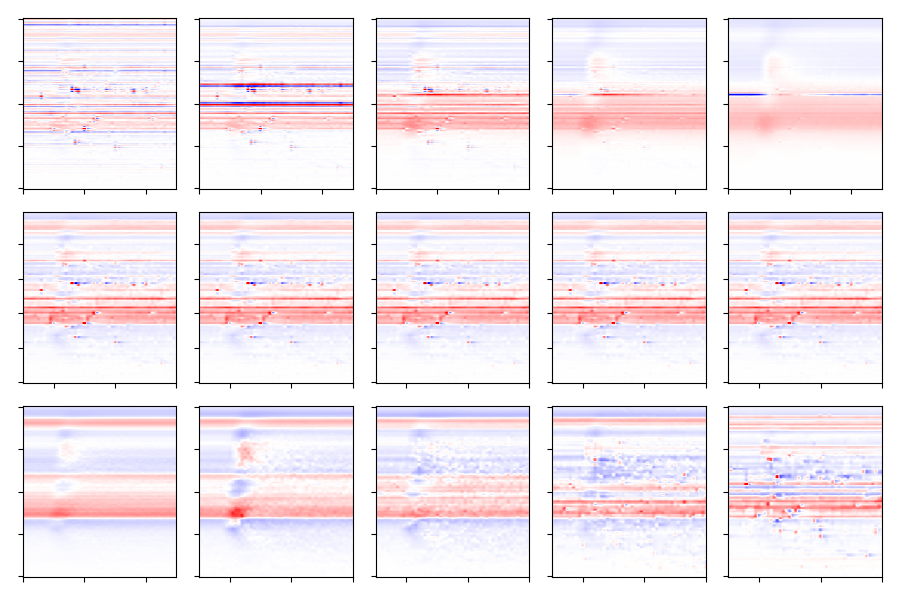

In [20]:
### This cell plots Figure 3 a

fig, axes = plt.subplots(3,5,figsize=(9,6))

for i in range(5):
    plotFig(axes[0][i],icsds[i].get_csd(),xlabels=False)
    plotFig(axes[1][i],noNeg.T,timeLimited=True,xlabels=False)


plotFig(axes[2][0],disk500.T,xlabels=False,timeLimited=False)

plotFig(axes[2][1],disk200.T,xlabels=False,timeLimited=True)

plotFig(axes[2][2],disk100.T,xlabels=False,timeLimited=True)

plotFig(axes[2][3],disk50.T,xlabels=False,timeLimited=True)

plotFig(axes[2][4],disk20.T,xlabels=False,timeLimited=True)


plt.savefig('figures/20um.png',dpi=300)

In [21]:
### This cell calcualtes the correlation between iCSD and objective disk CSD for each of the values of rho, for 20 um electrode spacing

correlations_500 = []
correlations_200 = []
correlations_100 = []
correlations_50 = []
correlations_20 = []
correlations_10 = []


for i in np.arange(2000,2050):
    correlations_500.append(np.corrcoef(icsds[0].get_csd()[1:-1,i],disk500.T[1:-1,i])[0,1])
    correlations_200.append(np.corrcoef(icsds[1].get_csd()[1:-1,i],disk200.T[1:-1,i-1950])[0,1])
    correlations_100.append(np.corrcoef(icsds[2].get_csd()[1:-1,i],disk100.T[1:-1,i-1950])[0,1])
    correlations_50.append(np.corrcoef(icsds[3].get_csd()[1:-1,i],disk50.T[1:-1,i-1950])[0,1])
    correlations_20.append(np.corrcoef(icsds[4].get_csd()[1:-1,i],disk20.T[1:-1,i-1950])[0,1])
    correlations_10.append(np.corrcoef(icsds[5].get_csd()[:,i],disk10.T[:,i-1950])[0,1])



In [22]:
### This cell calcualtes the correlation between nnCSD and objective disk CSD for each of the values of rho, for 20 um electrode spacing

correlations_noNeg = []

correlations_500_noNeg = []
correlations_200_noNeg = []
correlations_100_noNeg = []
correlations_50_noNeg = []
correlations_20_noNeg = []
correlations_10_noNeg = []


for i in np.arange(2000,2050):
    correlations_noNeg.append(np.corrcoef(icsds[0].get_csd()[1:-1,i],noNeg.T[:,i-1950])[0,1])
    
    correlations_500_noNeg.append(np.corrcoef(disk500.T[1:-1,i],noNeg.T[:,i-1950])[0,1])
    correlations_200_noNeg.append(np.corrcoef(disk200.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_100_noNeg.append(np.corrcoef(disk100.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_50_noNeg.append(np.corrcoef(disk50.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_20_noNeg.append(np.corrcoef(disk20.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_10_noNeg.append(np.corrcoef(disk10.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])


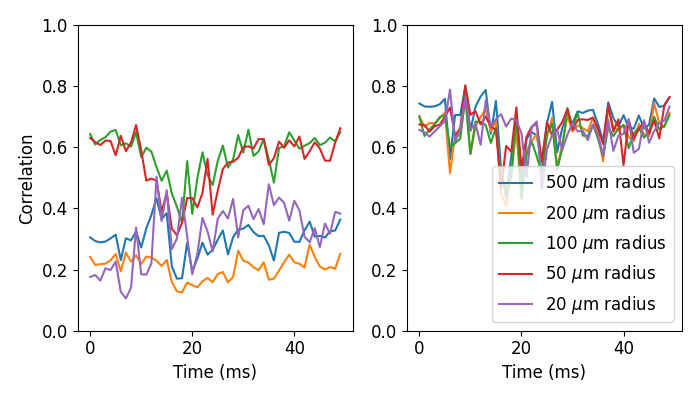

In [24]:
### This cell plots Figure 3 b and c

plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
plt.plot(correlations_500)
plt.plot(correlations_200)
plt.plot(correlations_100)
plt.plot(correlations_50)
plt.plot(correlations_20)

plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.ylim([0,1])
# plt.xlim([15,30])

plt.subplot(1,2,2)
plt.plot(correlations_500_noNeg)
plt.plot(correlations_200_noNeg)
plt.plot(correlations_100_noNeg)
plt.plot(correlations_50_noNeg)
plt.plot(correlations_20_noNeg)

plt.ylim([0,1])
# plt.xlim([15,30])
plt.legend(['500 $\mu$m radius','200 $\mu$m radius','100 $\mu$m radius','50 $\mu$m radius', '20 $\mu$m radius'])#,'nnCSD vs oCSD 10','nnCSD vs oCSD 5','nnCSD vs oCSD 2'])
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.savefig('figures/20umcorrelation.png',dpi=300)

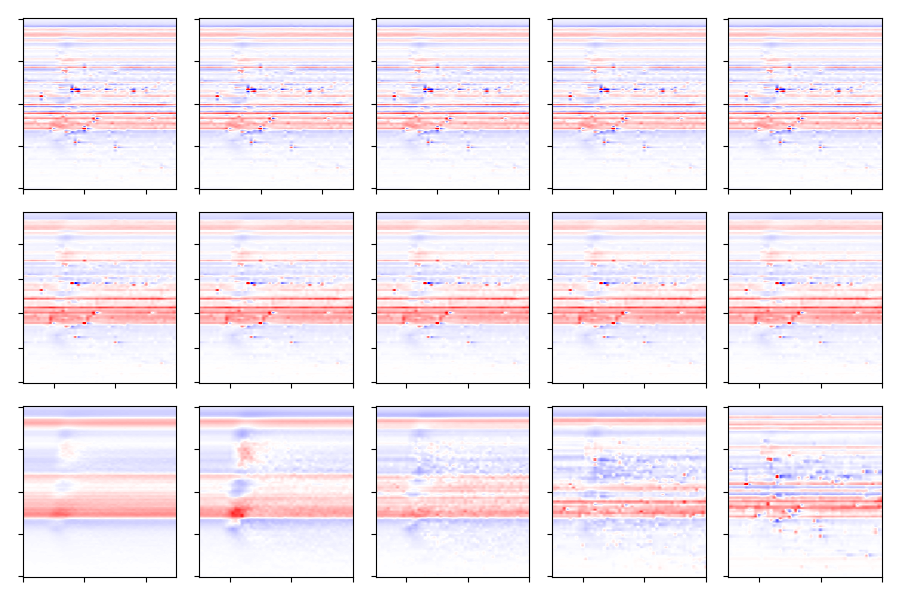

In [27]:
### This cell plots Figure 4 a

fig, axes = plt.subplots(3,5,figsize=(9,6))

for i in range(5):
    plotFig(axes[0][i],icsd_high_std.get_csd(),xlabels=False)
    plotFig(axes[1][i],noNeg.T,timeLimited=True,xlabels=False)


plotFig(axes[2][0],disk500.T,xlabels=False,timeLimited=False)

plotFig(axes[2][1],disk200.T,xlabels=False,timeLimited=True)

plotFig(axes[2][2],disk100.T,xlabels=False,timeLimited=True)

plotFig(axes[2][3],disk50.T,xlabels=False,timeLimited=True)

plotFig(axes[2][4],disk20.T,xlabels=False,timeLimited=True)


plt.savefig('figures/20um_standard.png',dpi=300)

In [28]:
### This cell calcualtes the correlation between sCSD and objective disk CSD, for all values of rho, for the 20 um electrode spacing

correlations_500_std = []
correlations_200_std = []
correlations_100_std = []
correlations_50_std = []
correlations_20_std = []
correlations_10_std = []


for i in np.arange(2000,2050):
    correlations_500_std.append(np.corrcoef(icsd_high_std.get_csd()[1:-1,i],disk500.T[1:-1,i])[0,1])
    correlations_200_std.append(np.corrcoef(icsd_high_std.get_csd()[1:-1,i],disk200.T[1:-1,i-1950])[0,1])
    correlations_100_std.append(np.corrcoef(icsd_high_std.get_csd()[1:-1,i],disk100.T[1:-1,i-1950])[0,1])
    correlations_50_std.append(np.corrcoef(icsd_high_std.get_csd()[1:-1,i],disk50.T[1:-1,i-1950])[0,1])
    correlations_20_std.append(np.corrcoef(icsd_high_std.get_csd()[1:-1,i],disk20.T[1:-1,i-1950])[0,1])
    correlations_10_std.append(np.corrcoef(icsd_high_std.get_csd()[:,i],disk10.T[:,i-1950])[0,1])

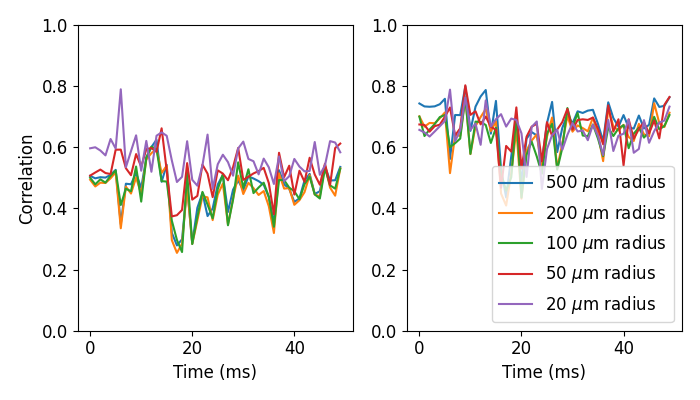

In [29]:
### This cell plots Figure 4 b and c

plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
plt.plot(correlations_500_std)
plt.plot(correlations_200_std)
plt.plot(correlations_100_std)
plt.plot(correlations_50_std)
plt.plot(correlations_20_std)

plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.ylim([0,1])
# plt.xlim([15,30])

plt.subplot(1,2,2)
plt.plot(correlations_500_noNeg)
plt.plot(correlations_200_noNeg)
plt.plot(correlations_100_noNeg)
plt.plot(correlations_50_noNeg)
plt.plot(correlations_20_noNeg)

plt.ylim([0,1])
# plt.xlim([15,30])
plt.legend(['500 $\mu$m radius','200 $\mu$m radius','100 $\mu$m radius','50 $\mu$m radius', '20 $\mu$m radius'])#,'nnCSD vs oCSD 10','nnCSD vs oCSD 5','nnCSD vs oCSD 2'])
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.savefig('figures/20umcorrelation_std.png',dpi=300)